In [1]:
# get processed data

import os
import pandas as pd

file_path = "../data/"

data = pd.read_csv(file_path+"train.csv")

In [2]:
# Convert to list

df=data["news_title"]

docs = [str(i) for i in df.values]


In [3]:

import torch
from transformers import BertModel, BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("setu4993/LaBSE")
model = BertModel.from_pretrained("setu4993/LaBSE")

# Set model to evaluation mode

model.eval()


"""
Encode a batch of documents using LaBSE model and return their embeddings.
Args:
    docs: List of strings representing the documents to be encoded.
    batch_size: Size of the batch to be used during encoding.
Returns:
    embeddings: Tensor of shape (n_docs, embedding_size) representing the document embeddings.
"""
# Encode the documents in batches

n_docs = len(docs)
batch_size = 8
embeds = torch.zeros((n_docs, model.config.hidden_size))
for i in range(0, n_docs, batch_size):
    batch = docs[i:i+batch_size]
    inputs = tokenizer(batch, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    batch_embeddings = outputs.pooler_output
    embeds[i:i+batch_size] = batch_embeddings


/Users/samyuktha/opt/anaconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Tokenize docs trivially (split on spaces)

from indicnlp.tokenize import sentence_tokenize, indic_tokenize

def tokenize_ta(text,return_tensors="pt",*args,**kwargs):
    return indic_tokenize.trivial_tokenize(text)

In [5]:
# Common list of stopwords

stopwords=['அங்கு',
 'அங்கே',
 'அடுத்த',
 'அதனால்',
 'அதன்',
 'அதற்கு',
 'அதிக',
 'அதில்',
 'அது',
 'அதே',
 'அதை',
 'அந்த',
 'அந்தக்',
 'அந்தப்',
 'அன்று',
 'அல்லது',
 'அவன்',
 'அவரது',
 'அவர்',
 'அவர்கள்',
 'அவள்',
 'அவை',
 'ஆகிய',
 'ஆகியோர்',
 'ஆகும்',
 'இங்கு',
 'இங்கே',
 'இடத்தில்',
 'இடம்',
 'இதனால்',
 'இதனை',
 'இதன்',
 'இதற்கு',
 'இதில்',
 'இது',
 'இதை',
 'இந்த',
 'இந்தக்',
 'இந்தத்',
 'இந்தப்',
 'இன்னும்',
 'இப்போது',
 'இரு',
 'இருக்கும்',
 'இருந்த',
 'இருந்தது',
 'இருந்து',
 'இவர்',
 'இவை',
 'உன்',
 'உள்ள',
 'உள்ளது',
 'உள்ளன',
 'எந்த',
 'என',
 'எனக்',
 'எனக்கு',
 'எனப்படும்',
 'எனவும்',
 'எனவே',
 'எனினும்',
 'எனும்',
 'என்',
 'என்ன',
 'என்னும்',
 'என்பது',
 'என்பதை',
 'என்ற',
 'என்று',
 'என்றும்',
 'எல்லாம்',
 'ஏன்',
 'ஒரு',
 'ஒரே',
 'ஓர்',
 'கொண்ட',
 'கொண்டு',
 'கொள்ள',
 'சற்று',
 'சிறு',
 'சில',
 'சேர்ந்த',
 'தனது',
 'தன்',
 'தவிர',
 'தான்',
 'நான்',
 'நாம்',
 'நீ',
 'பற்றி',
 'பற்றிய',
 'பல',
 'பலரும்',
 'பல்வேறு',
 'பின்',
 'பின்னர்',
 'பிற',
 'பிறகு',
 'பெரும்',
 'பேர்',
 'போது',
 'போன்ற',
 'போல',
 'போல்',
 'மட்டுமே',
 'மட்டும்',
 'மற்ற',
 'மற்றும்',
 'மிக',
 'மிகவும்',
 'மீது',
 'முதல்',
 'முறை',
 'மேலும்',
 'மேல்',
 'யார்',
 'வந்த',
 'வந்து',
 'வரும்',
 'வரை',
 'வரையில்',
 'விட',
 'விட்டு',
 'வேண்டும்',
 'வேறு']

from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts for topic representation - TOKENIZATION STEP

vectorizer_model = CountVectorizer(
    stop_words=stopwords,analyzer='word',
    tokenizer=tokenize_ta
)

In [6]:

# Create a BERTopic model

from bertopic import BERTopic
from datetime import datetime

topic_numbers = []
score = []
time=[]

for i in range(15,115,10):

    topic_model = BERTopic(
        vectorizer_model=vectorizer_model,
        verbose=True,
        calculate_probabilities=False,
        embedding_model=model,
        nr_topics=i,
    )

    # Fit the model on the documents

    embeds_np = embeds.detach().numpy()

    start_time = datetime.now()
    topics = topic_model.fit_transform(docs,embeds_np)
    end_time = datetime.now()
    time_taken = datetime.now() - start_time

    import gensim.corpora as corpora
    from gensim.models.coherencemodel import CoherenceModel

    # Preprocess documents

    cleaned_docs = topic_model._preprocess_text(docs)

    # Extract vectorizer and tokenizer from BERTopic

    vectorizer = topic_model.vectorizer_model
    tokenizer = vectorizer.build_tokenizer()

    # Extract features for Topic Coherence evaluation

    words = vectorizer.get_feature_names_out()
    tokens = [tokenizer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
                for topic in range(len(topic_model.get_topics())-1)]


    # Evaluate

    from gensim.models import KeyedVectors
    from gensim.models import word2vec
    from gensim import corpora, models

    # Load pre-trained Word2Vec model for Tamil language

    model_path = "/Users/samyuktha/FYP/data/cc.ta.300.vec.gz"
    w2v_model = KeyedVectors.load_word2vec_format(model_path)

    # Compute coherence score using Word2Vec similarity measure

    cm = CoherenceModel(topics=topic_words, 
                                    texts=tokens, 
                                    corpus=corpus,
                                    dictionary=dictionary, 
    coherence='c_w2v',keyed_vectors=w2v_model)

    coherence_score = cm.get_coherence()

    topic_numbers.append(i)
    score.append(coherence_score)
    time.append(time_taken)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2023-04-28 12:11:28,787 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-04-28 12:11:31,016 - BERTopic - Clustered reduced embeddings
2023-04-28 12:11:39,476 - BERTopic - Reduced number of topics from 530 to 15
2023-04-28 12:14:37,461 - BERTopic - Reduced dimensionality
2023-04-28 12:14:38,728 - BERTopic - Clustered reduced embeddings
2023-04-28 12:14:45,939 - BERTopic - Reduced number of topics from 533 to 25
2023-04-28 12:17:41,787 - BERTopic - Reduced dimensionality
2023-04-28 12:17:43,012 - BERTopic - Clustered reduced embeddings
2023-04-28 12:17:50,317 - BERTopic - Reduced number of topics from 525 to 35
2023-04-28 12:20:46,605 - BERTopic - Reduced dimensionality
2023-04-28 12:20:47,883 - BERTopic - Clustered reduced embeddings
2023-04-28 12:20:55,508 - BERTopic - Reduced number of topics from 529 to 45
2023-04-28 12:23:54,265 - BERTopic - Reduced dimensionality
2023-04-28 12:23:55,531 - BERTopic - Clustered reduced embeddings
2023-04-28 12:24:03,381 - BERTopic - Reduced number of topics from 559 to 55
2023-04-28 12:27:02,595 - BERTopic - Reduced 

In [7]:
scores=pd.DataFrame({"topics":topic_numbers,"score":score,"time": [x.total_seconds() for x in time]})

scores

,topics,score,time
0,15,0.553352,41.815031
1,25,0.571918,20.921819
2,35,0.576912,20.576020
3,45,0.563568,20.962175
4,55,0.573845,22.545462
5,65,0.567374,22.532765
6,75,0.568953,21.758978
7,85,0.565945,22.336348
8,95,0.574171,23.371316
9,105,0.568674,22.927003


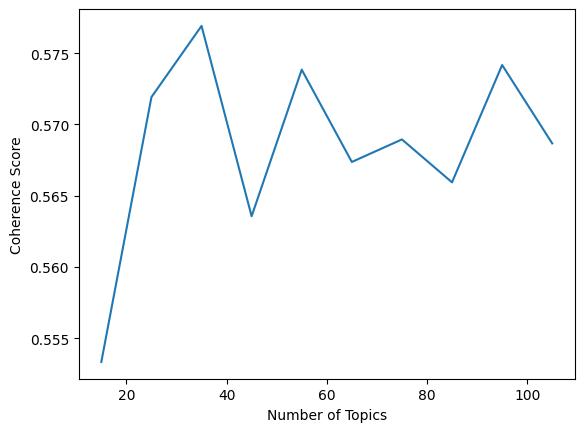

In [8]:
# Plot the coherence score for different number of topics

import matplotlib.pyplot as plt
plt.plot(topic_numbers, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [9]:
topic_model.visualize_barchart()